In [1]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools
import cftime

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature
import matplotlib.cm as cm
import cmocean.cm as cmo
import matplotlib.ticker as ticker
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches


ccrs = cartopy.crs

In [2]:
nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='darkgray')

In [3]:
labelsize = 20

# Describe streamfunction metrics

## BSF

In [4]:
# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [15.0, 66.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
maskBSF = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Subpolar Gyre')
maskBSF = maskBSF.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
#bsf_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/BSF_anomaly.nc'
#anom_bsf_ds = xr.open_dataarray(bsf_file).roll(nlon=+100).where(maskBSF == 1)

bsf_ds = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/BSFcomposite-test.nc').roll(nlon=+100).where(maskBSF == 1)

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_temp = xr.open_dataset(temp_file).isel(time=0, z_t=0).squeeze().roll(nlon=+100).where(maskBSF == 1)

replacement_value = 0
ds_temp['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_temp['ULAT']), np.isinf(ds_temp['ULAT']) | np.ma.getmask(ds_temp['ULAT'])),
    replacement_value,
    ds_temp['ULAT']
)

ds_temp['ULONG'] = xr.where(
    np.logical_or(np.isnan(ds_temp['ULONG']), np.isinf(ds_temp['ULONG']) | np.ma.getmask(ds_temp['ULONG'])),
    replacement_value,
    ds_temp['ULONG']
)

In [11]:
vmin = -60
vmax = -vmin

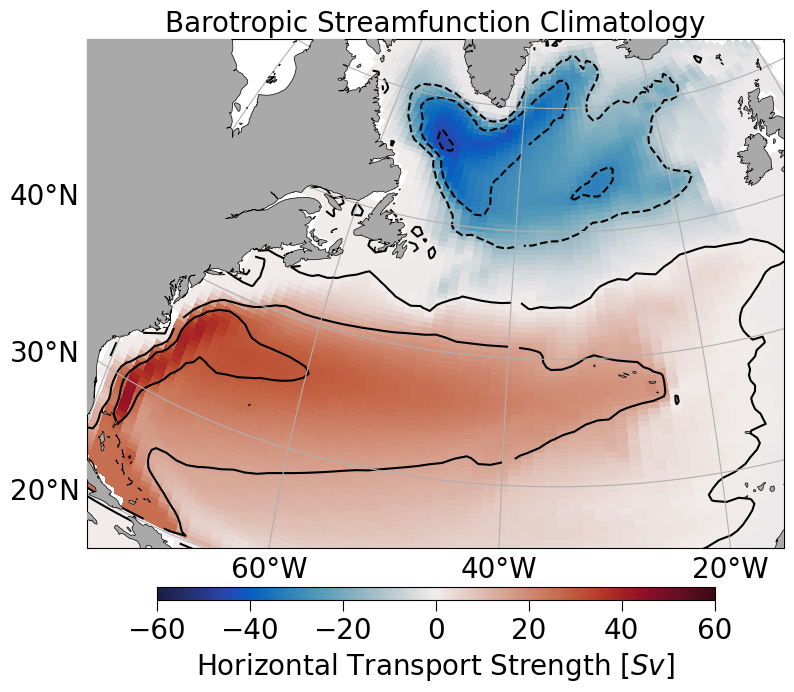

In [13]:
cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Horizontal Transport Strength [$Sv$]', 'pad': 0.05}

fig, ax = plt.subplots(figsize=(9, 10), subplot_kw={'projection': ccrs.Orthographic(central_latitude=40, central_longitude=-35)})
ax.set_extent([-80, -15, 25, 60], crs=ccrs.PlateCarree())

pc = ax.pcolormesh(ds_temp.ULONG, ds_temp.ULAT, bsf_ds.isel(time=slice(0,40)).mean('time'), 
                   transform=ccrs.PlateCarree(),
                   cmap=cmo.balance, vmin=vmin, vmax=vmax)

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize, size=8)

ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': labelsize}
gl.ylabel_style = {'size': labelsize}

plt.contour(ds_temp.ULONG, ds_temp.ULAT, bsf_ds.isel(time=slice(0,40)).mean('time'), 
                   transform=ccrs.PlateCarree(), colors='k')
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='darkgray'), zorder=10)
ax.set_title('Barotropic Streamfunction Climatology', fontsize=labelsize)

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'climatology_bsf.png', bbox_inches='tight', dpi=300, transparent=True)

## dMOC

In [14]:
#dmoc_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/dMOC_anomaly.nc'
#anom_dmoc_ds = xr.open_dataarray(dmoc_file)

dmoc_ds = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/dMOCcomposite-test.nc')

ps_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'

ds_ps = xr.open_dataset(ps_file).isel(time=0, nlon=0).squeeze()
replacement_value = 0

ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT'])

ds_ps['z_t'] = ds_ps.z_t *1e-2

In [19]:
vmin = -30
vmax = -vmin

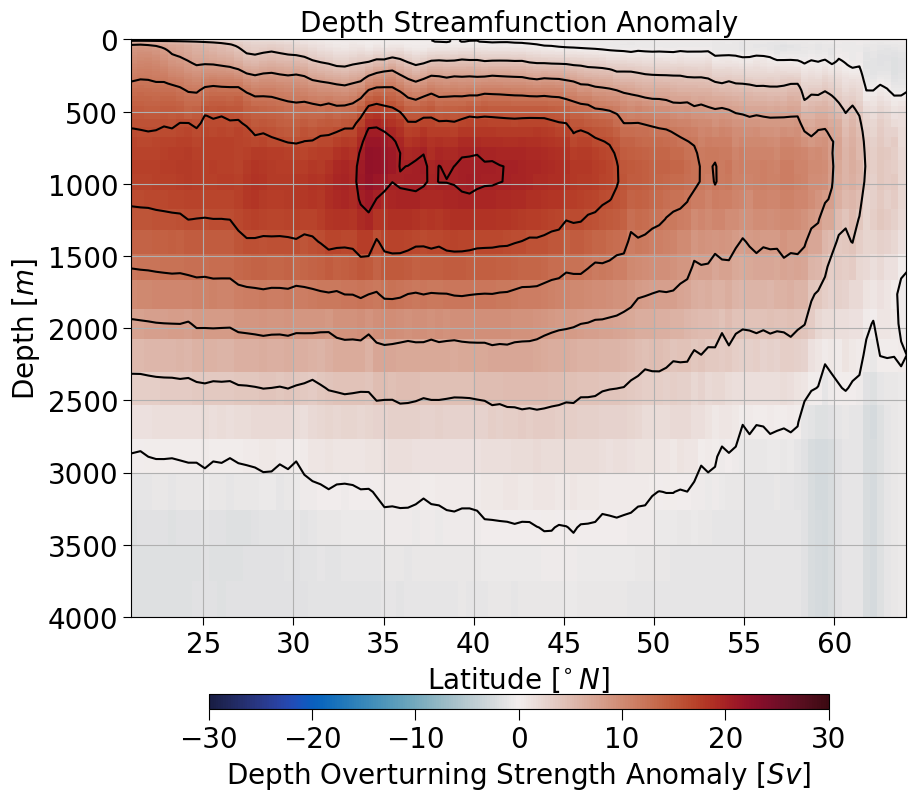

In [25]:
labelsize = 20

cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Depth Overturning Strength Anomaly [$Sv$]', 'pad': 0.1}

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds_ps.ULAT, ds_ps.z_t, dmoc_ds.isel(time=slice(0,40)).mean('time'),
                   cmap=cmo.balance,
                   vmin=vmin, vmax=vmax)

plt.contour(ds_ps.ULAT, ds_ps.z_t, dmoc_ds.isel(time=slice(0,40)).mean('time'), colors='k')

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize, size=8)

ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)
ax.set_title('Depth Streamfunction Anomaly', fontsize=labelsize)


ax.invert_yaxis()
ax.set_xlim([21, 64]) 

ax.set_ylim([4000, 0]) 
plt.grid()


plt.ylabel(r'Depth [$m$]', fontsize = labelsize)
plt.xlabel(r'Latitude [$^{\circ}\,N$]', fontsize = labelsize)

#plt.show()

plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'climatology_dmoc.png', bbox_inches='tight', dpi=300, transparent=True)

## sMOC

In [27]:
smoc_ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite.nc')

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_ps = xr.open_dataset(temp_file).isel(time=0, nlon=0).squeeze()

replacement_value = 0


# Replace non-finite values and masked values
ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT']
)

#smoc_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/sMOC_anomaly.nc'
#anom_smoc_ds = xr.open_dataset(smoc_file)

In [30]:
vmin = -30
vmax = -vmin

sigma_level =[12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4,
                   33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 
                   36.4, 36.42, 36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 
                   36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 
                   36.78, 36.8, 36.82, 36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 
                   37.14, 37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
fake_sigma = np.arange(len(sigma_level))

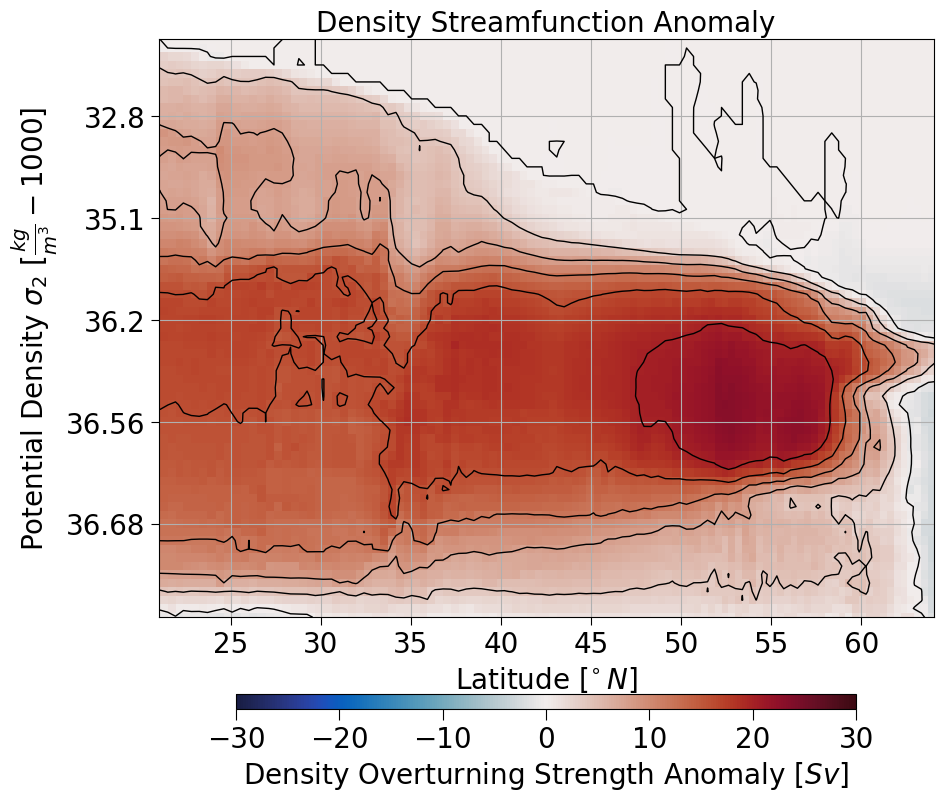

In [33]:
labelsize = 20

cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Density Overturning Strength Anomaly [$Sv$]', 'pad': 0.1}

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds_ps.TLAT.isel(nlat=(slice(250,365))), fake_sigma, smoc_ds.densMOC.isel(time=slice(0,40)).mean('time'),
                   cmap=cmo.balance,
                   vmin=vmin, vmax=vmax)

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize , size=8)

plt.contour(ds_ps.ULAT.isel(nlat=(slice(250,365))), fake_sigma, smoc_ds.densMOC.isel(time=slice(0,40)).mean('time'), 
            linewidths=1, colors='k')

ax.tick_params(axis='both', which='both', labelsize=labelsize , size=6)
ax.set_title('Density Streamfunction Anomaly', fontsize=labelsize )

plt.yticks(np.arange(len(sigma_level))[::12], sigma_level[::12])

ax.set_xlim([21, 64])  
ax.set_ylim([15, 83])  

plt.ylabel(r'Potential Density $\sigma_2$ [$\frac{kg}{m^3} -1000$]', fontsize = labelsize )
plt.xlabel(r'Latitude [$^{\circ}\,N$]', fontsize = labelsize )

plt.gca().invert_yaxis()

plt.grid()

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'climatology_smoc.png', bbox_inches='tight', dpi=300, transparent=True)

## sMOC all members time series

In [4]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
files = sorted(glob.glob(os.path.join(path, '*monthly_smoc55_member_*.nc')))

In [5]:
annual_means = []

for file in files:
    ds = xr.open_dataset(file)
    monthly_mean = ds.__xarray_dataarray_variable__
    annual_mean = monthly_mean.resample(time='1Y').mean().values
    annual_means.append(annual_mean)
    
# Find the maximum length of all arrays
max_length = max(len(arr) for arr in annual_means)

# Pad arrays to the same length
annual_means_padded = []
for arr in annual_means:
    if len(arr) < max_length:
        padded_arr = np.pad(arr, (0, max_length - len(arr)), constant_values=np.nan)
    else:
        padded_arr = arr
    annual_means_padded.append(padded_arr)

# Convert the list of padded arrays to a NumPy array
annual_means_array = np.stack(annual_means_padded, axis=0)

ensemble_mean = np.nanmean(annual_means_array, axis=0)

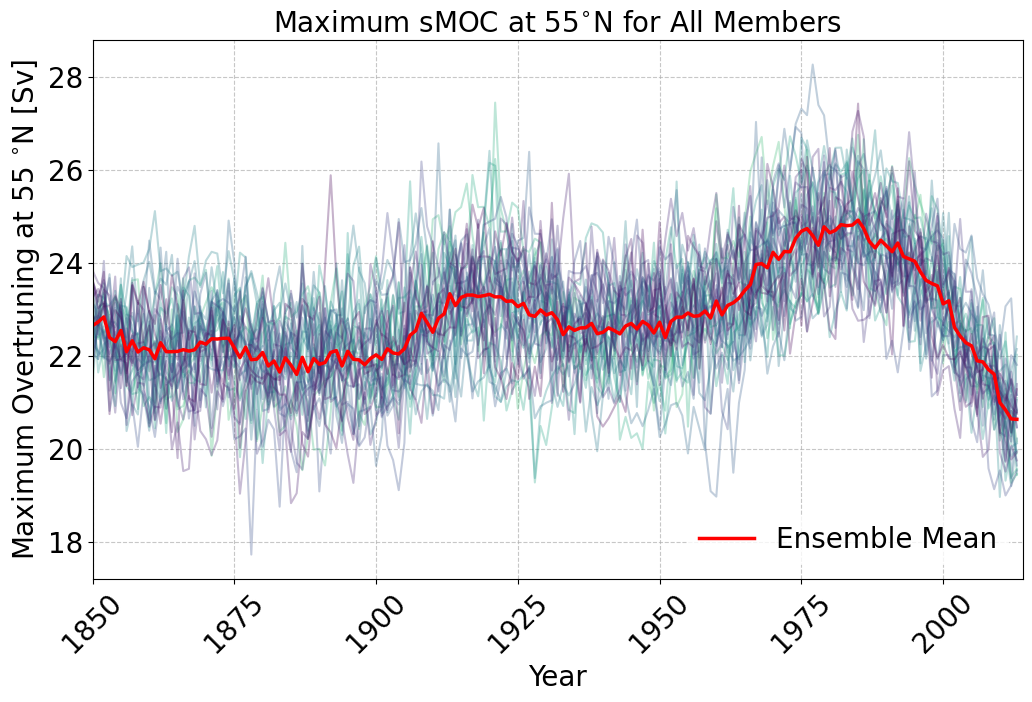

In [19]:
# Use the viridis colormap to assign colors to the annual means
colors = cm.viridis_r(np.linspace(0.3, 1, len(annual_means_array)))

plt.figure(figsize=(12, 7))

# Plot each annual mean with a different color from the 'colors' array
for idx, annual_mean in enumerate(annual_means_array):
    plt.plot(annual_mean[:164], alpha=0.3, color=colors[idx])

# Plot the ensemble mean in 'red' and make it stand out
plt.plot(ensemble_mean[:164], color='red', linewidth=2.5, label='Ensemble Mean')

# Adding a title and axis labels with the specified labelsize
plt.title(r'Maximum sMOC at 55$^{\circ}$N for All Members', fontsize=labelsize)
plt.xlabel('Year', fontsize=labelsize)
plt.ylabel('Maximum Overtruning at 55 $^{\circ}$N [Sv]', fontsize=labelsize)

# Adjusting the x-axis from 1850 to 2010 with the specified labelsize for ticks
plt.xlim(0, 164)
plt.xticks(ticks=np.arange(0, 165, 25), labels=np.arange(1850, 2015, 25), fontsize=labelsize, rotation=45)
plt.yticks(fontsize=labelsize)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding a legend with the specified labelsize, white background, and no border
legend = plt.legend(fontsize=labelsize, frameon=True, facecolor='white', edgecolor='white', loc='lower right')
legend.get_frame().set_linewidth(0)

# Show the plot
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'all_members_annual_smoc.png', bbox_inches='tight', dpi=300, transparent=True)

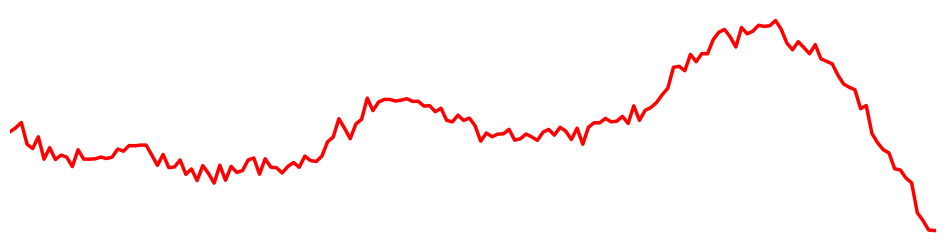

In [24]:
plt.figure(figsize=(12, 3), facecolor='none')

# Plot the ensemble mean in 'red' and make it stand out
plt.plot(ensemble_mean[:164], color='red', linewidth=2.5)

# Remove axis ticks, labels, and spines to achieve a transparent background
ax = plt.gca()
ax.set_facecolor('none')  # Set the axes background to transparent
ax.get_xaxis().set_visible(False)  # Hide the x-axis
ax.get_yaxis().set_visible(False)  # Hide the y-axis
for spine in ax.spines.values():
    spine.set_visible(False)  # Hide the spines

# Adjust the x-axis from 1850 to 2010
plt.xlim(0, 164)

# Show the plot with a transparent background
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'line_mean_annual_smoc.png', bbox_inches='tight', dpi=300, transparent=True)

## Method

In [ ]:
# Define parameters
raw_files = glob.glob(os.path.expanduser('~/phase1_CONDA/') + 'timeseries/*time_series.npy')
h = 7
window_size = 40
duration_threshold = 20
threshold_multiple = 3

# Load signal data for the first plot
signals = np.load(raw_files[7])
hist_end = (2014 - 1850) * 12
signals = signals[:hist_end]
time_annual = np.arange(1850, 1850 + (hist_end / 12))

# Read the order file
with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
    vvel_list = file.readlines()
vvel_dict = {int(line.split()[0]): line.split()[1] for line in vvel_list}

# Load data from 'events_dens_spg.csv' to get member numbers
data = np.genfromtxt('events_dens_spg.csv', delimiter=',', names=True, dtype=None)
member_numbers = data['Index']

# Process data for the first plot
last_member_name = vvel_dict[member_numbers[-3]][5:]
signal = signals[:, member_numbers[-3]][:hist_end]
annual_mean = np.mean(signal.reshape(-1, 12), axis=1)

# Identify events for the second plot
criteria_indices_dict = {}

for i, signal in enumerate(signals.T):
    annual_means = np.mean(signal.reshape(-1, 12), axis=1)
    criteria_indices = []
    for j in range(window_size, len(annual_means) - duration_threshold):
        window = annual_means[j - window_size:j]
        std_window = np.std(window)
        avg_window = np.mean(window)
        threshold = annual_means[j:j + duration_threshold]
        avg_threshold = np.mean(threshold)
        if avg_threshold >= avg_window + (threshold_multiple * std_window) or avg_threshold <= avg_window - (threshold_multiple * std_window):
            if len(criteria_indices) == 0 or j >= criteria_indices[-1] + duration_threshold:
                criteria_indices.append(j)
                print(j)
    criteria_indices_dict[i] = criteria_indices

result = [(index, value) for index, value in criteria_indices_dict.items() if value]

with open('events_dens_spg.csv', 'w', newline='') as csvfile:
    fieldnames = ['Index', 'Values']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for index, values in result:
        writer.writerow({'Index': index, 'Values': values[0]})

# Save event and member names
saved_data = []
for index, values in result:
    file_name = vvel_dict[index][5:-3]
    annual_means = np.mean(signals[:, index].reshape(-1, 12), axis=1)
    start = values[0]
    end = values[0] + duration_threshold
    event = annual_means[start - window_size:end]
    saved_data.append((file_name, event))

sorted_data = sorted(saved_data, key=lambda x: x[0])

IndexError: index -3 is out of bounds for axis 0 with size 0

NameError: name 'annual_mean' is not defined

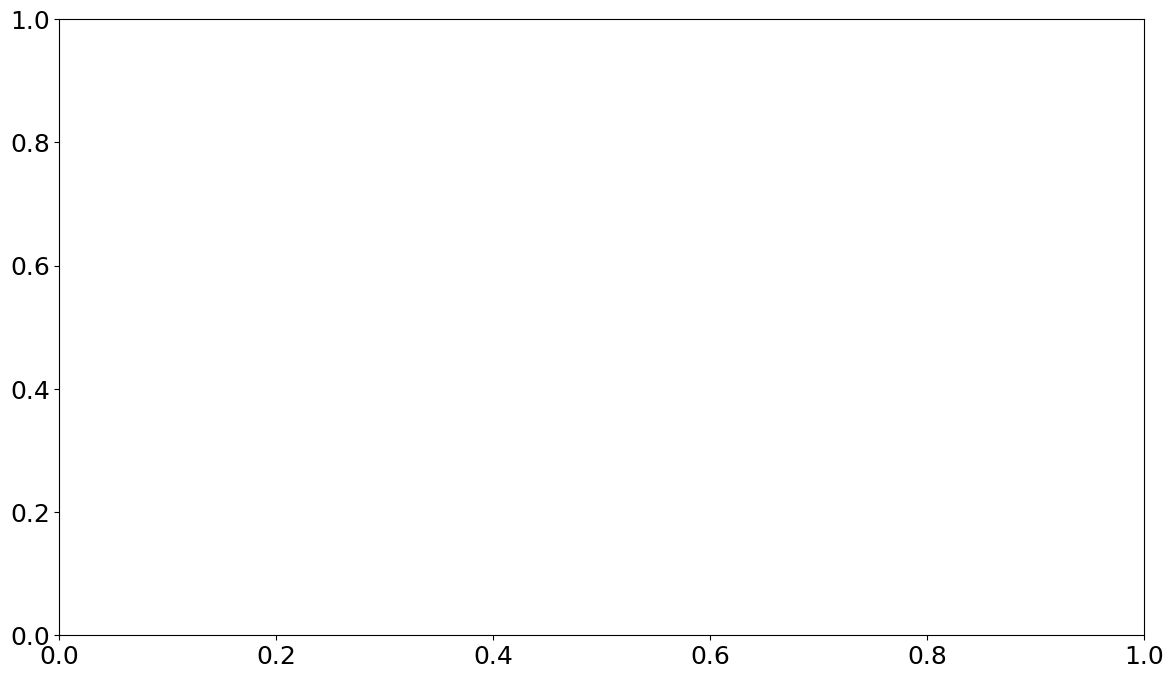

In [ ]:
# Create the first figure
fig1, ax1 = plt.subplots(figsize=(14, 8))

event_location = 107
period_1 = np.mean(annual_mean[event_location - 40: event_location-1])
period_2 = np.mean(annual_mean[event_location+1: event_location + 20])
length = len(annual_mean)
colors = cm.viridis(np.linspace(0.1, 0.7, len(annual_mean)))

ax1.plot(time_annual, annual_mean, linewidth=2, color=colors[-5])
ax1.set_title('Abrupt event in historical period of member ' + last_member_name[:-3], fontsize=20)
ax1.tick_params(axis='x', labelsize=16, rotation=45)
ax1.tick_params(axis='y', labelsize=16)
ax1.locator_params(axis='x', nbins=8)
ax1.locator_params(axis='y', nbins=5)
ax1.grid(axis='x', linestyle='--', alpha=0.7)

# Set definition ranges
y_min, y_max = ax1.get_ylim()
y_length = (y_max - y_min)
vertical_position = 1850+107
ax1.axvline(x=vertical_position, color='r', linestyle='--', linewidth=4,
            ymin=(period_1-y_min)/y_length, ymax=(period_2-y_min)/y_length)
ax1.axhline(y=period_1, color=colors[0], linewidth=10,
            xmin=(event_location - 40) / length, xmax=(event_location-2.5) / length)
ax1.axhline(y=period_2, color=colors[3], linewidth=10,
            xmin=(event_location-0.5) / length, xmax=(event_location + 20) / length)

ax1.text(vertical_position + 3, 0.49 * (period_1 + period_2), r'$\mathbf{> 3 \sigma}$', color='r', fontsize=25)
ax1.text(vertical_position - 15, 0.455 * (period_1 + period_2), 'Period 1', weight='bold', color=colors[0], fontsize=20)
ax1.text(vertical_position - 11, 0.535 * (period_1 + period_2), 'Period 2', weight='bold', color=colors[3], fontsize=20)

# Save the first figure
plt.tight_layout()
fig1.savefig(os.path.expanduser('~/phase1_CONDA/results/Method_1.png'), bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Identify events
criteria_indices_dict = {}

for i, signal in enumerate(signals.T):
    annual_means = np.mean(signal.reshape(-1, 12), axis=1)
    criteria_indices = []
    for j in range(window_size, len(annual_means) - duration_threshold):
        window = annual_means[j - window_size:j]
        std_window = np.std(window)
        avg_window = np.mean(window)
        threshold = annual_means[j:j + duration_threshold]
        avg_threshold = np.mean(threshold)
        if avg_threshold >= avg_window + (threshold_multiple * std_window) or avg_threshold <= avg_window - (threshold_multiple * std_window):
            if len(criteria_indices) == 0 or j >= criteria_indices[-1] + duration_threshold:
                criteria_indices.append(j)
    criteria_indices_dict[i] = criteria_indices

result = [(index, value) for index, value in criteria_indices_dict.items() if value]

# Load the saved data
data = []
for index, values in result:
    file_name = vvel_dict[index][5:-3]
    annual_means = np.mean(signals[:, index].reshape(-1, 12), axis=1)
    start = values[0]
    end = values[0] + duration_threshold
    event = annual_means[start - window_size:end]
    data.append((file_name, event))

sorted_data = sorted(data, key=lambda x: x[0])

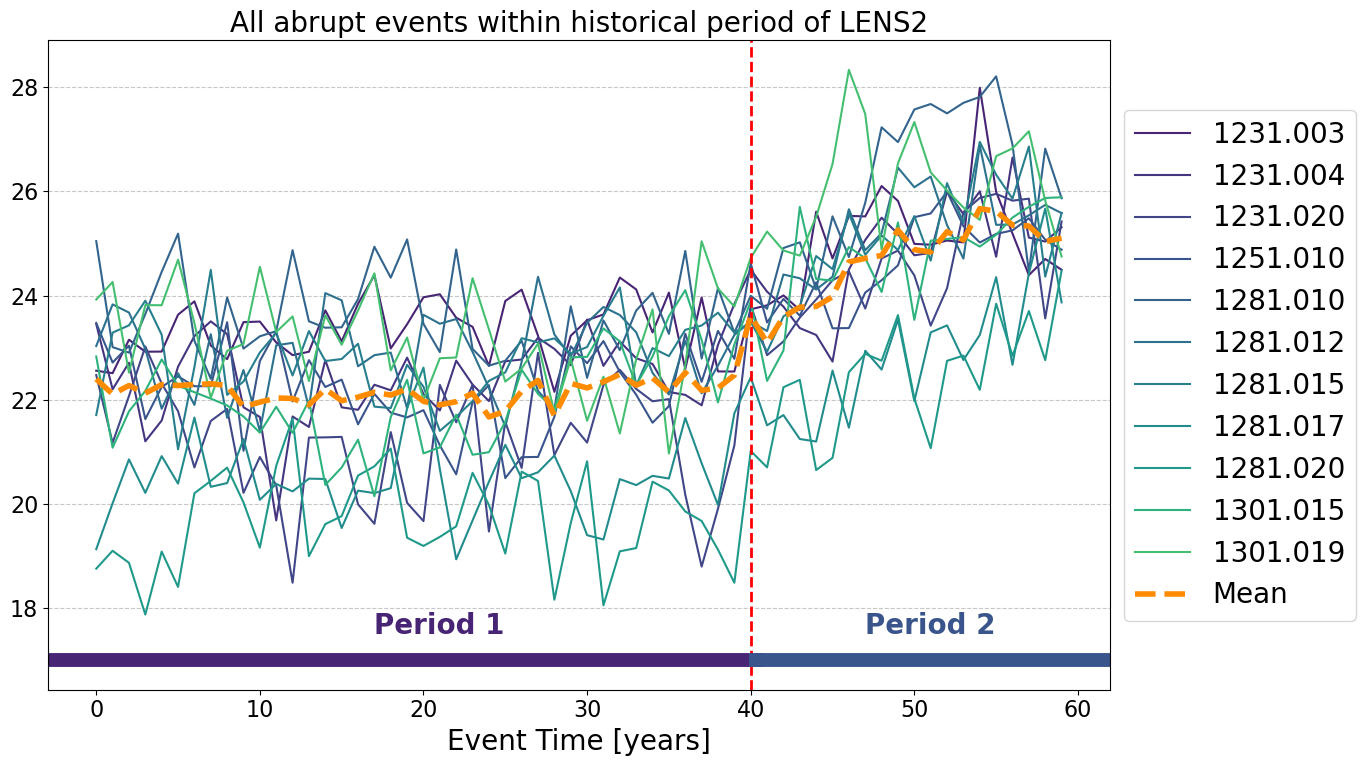

In [20]:
# Create the second figure
fig2, ax2 = plt.subplots(figsize=(14, 8))

colors = cm.viridis(np.linspace(0.1, 0.7, len(sorted_data[1:])))

time_series_list = []

for (file_name, timeseries), color in zip(sorted_data[1:], colors):
    if file_name != "1301.001":
        ax2.plot(timeseries, label=file_name, color=color)
        time_series_list.append(timeseries)

# Compute the mean time series
mean_time_series = np.mean(time_series_list, axis=0)

# Plot the mean time series
ax2.plot(mean_time_series, label='Mean', linestyle='--', color='darkorange', linewidth=4, zorder=110)

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
ax2.set_title(r'All abrupt events within historical period of LENS2', fontsize=20)
ax2.set_xlabel('Event Time [years]', fontsize=20)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

event_location = 40
length = 60
ax2.axvline(x=event_location, color='r', linestyle='--', linewidth=2)
ax2.axhline(y=17, color=colors[0], label='Period 1', linewidth=10, 
            xmin=(event_location - 40) / length, xmax=(event_location) / length)
ax2.axhline(y=17, color=colors[3], label='Period 2', linewidth=10, 
            xmin=(event_location) / length, xmax=(event_location + 20) / length)
ax2.text(17, 17.5, 'Period 1', weight='bold', color=colors[0], fontsize=20)
ax2.text(47, 17.5, 'Period 2', weight='bold', color=colors[3], fontsize=20)

# Save the second figure
plt.tight_layout()
fig2.savefig(os.path.expanduser('~/phase1_CONDA/results/Method_2.png'), bbox_inches='tight', dpi=300)
plt.show()

## Animation of hydrographic variables

In [4]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
maskBSF = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
maskBSF = maskBSF.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
variables = ['TEMP', 'SALT', 'SIGMA_2']
labels = [r'Temperature Anomaly $\Delta$T [$^{\circ} C$]', 
          r'Haline Anomaly $\Delta$S [$\frac{g}{kg}$]', 
          r'Potential Density Anomaly $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r]
vmins = [-0.9, -0.3, -0.2]

In [6]:
files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite*.nc'))

datasets = {var: xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/' + var + 'composite.nc').roll(nlon=+100) for var in variables}
replacement_value = 0
for ds in datasets.values():
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT'])
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG'])

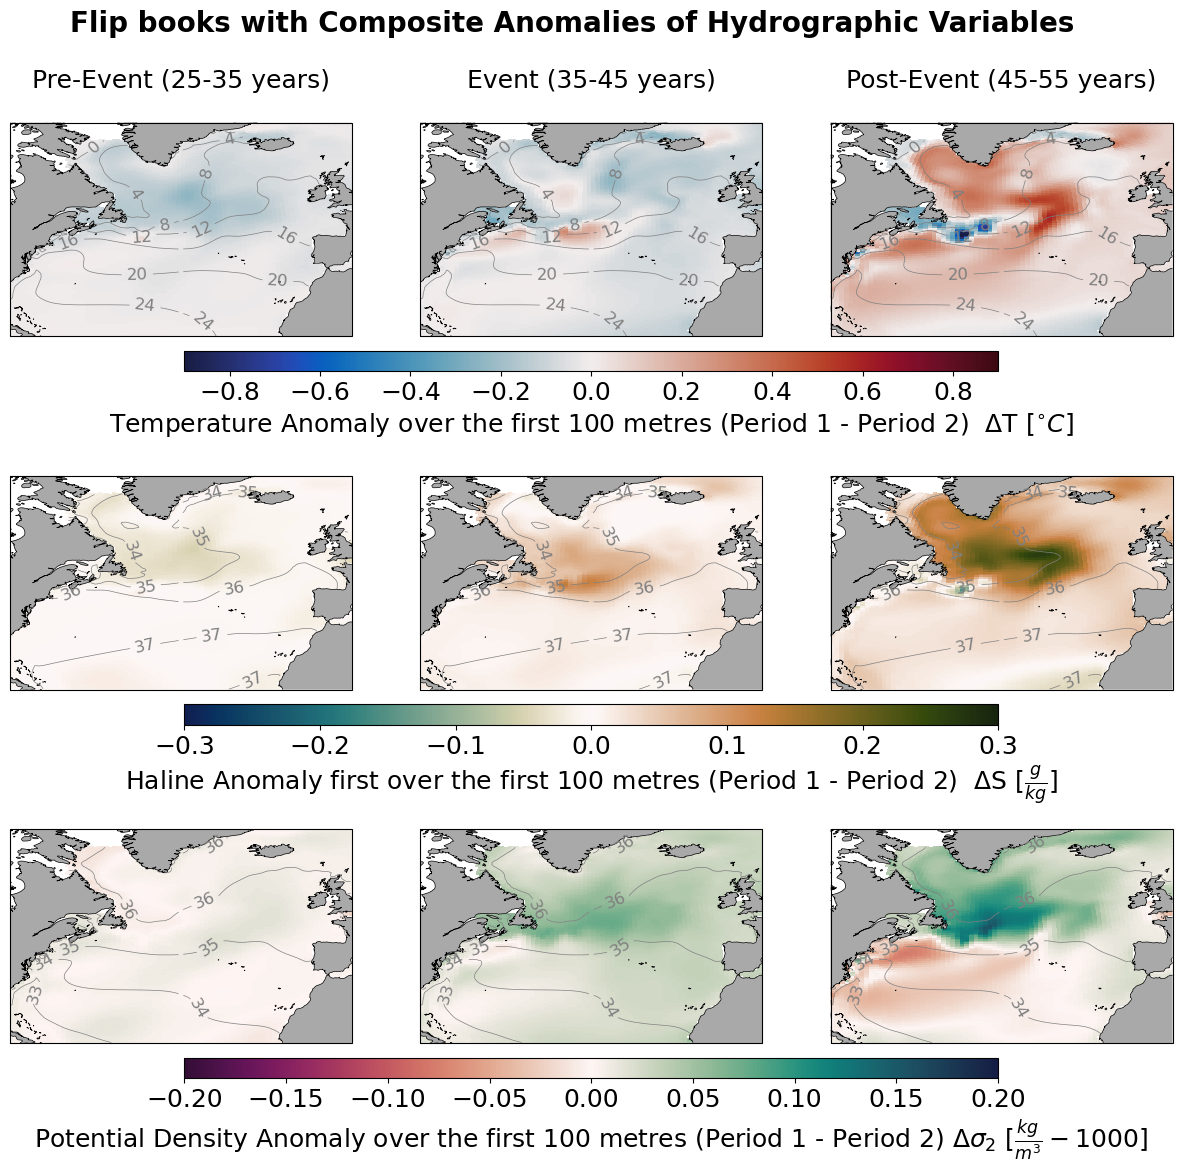

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 13), # (width, height)
                         subplot_kw={'projection': ccrs.PlateCarree()})
plt.rc('font', size=18)
years_ranges = [(25, 35), (35, 45), (45, 55)]
column_names = ['Pre-Event (25-35 years)', 'Event (35-45 years)', 'Post-Event (45-55 years)']

for row, var in enumerate(variables):
    ds_var_annual = datasets[var].sel(z_t=slice(5.0000000e+02, 1.050000e+04)).mean('z_t')
    ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
    vmin = vmins[row]
    vmax = -vmin
    for col, (start, end) in enumerate(years_ranges):
        ax = axes[row, col]
        pc = ds[var].isel(time=range(start, end)).mean('time').plot.pcolormesh(
            ax=ax, 
            transform=ccrs.PlateCarree(),
            x='TLONG', 
            y='TLAT',
            cmap=cmaps[row],
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        ) 
        ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
        #ax.coastlines(linewidth=1.5, color='black', alpha=0.8)
        ax.add_feature(nature_coast)
        cs = ax.contour(
            ds.TLONG, ds.TLAT, ds_var_annual[var].isel(time=slice(0, 40)).mean('time').where(maskBSF == 1), 
            linewidths=0.5, colors='gray', transform=ccrs.PlateCarree()
        )
        ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=12)
    cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)
    
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=18, pad=25)
fig.suptitle('Flip books with Composite Anomalies of Hydrographic Variables', fontsize=20, fontweight='bold', x=0.5, y=0.95) # bottom-left (0, 0) and top-right (1, 1)

plt.show()
#plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'Figure_5.png', bbox_inches='tight', dpi=300)

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

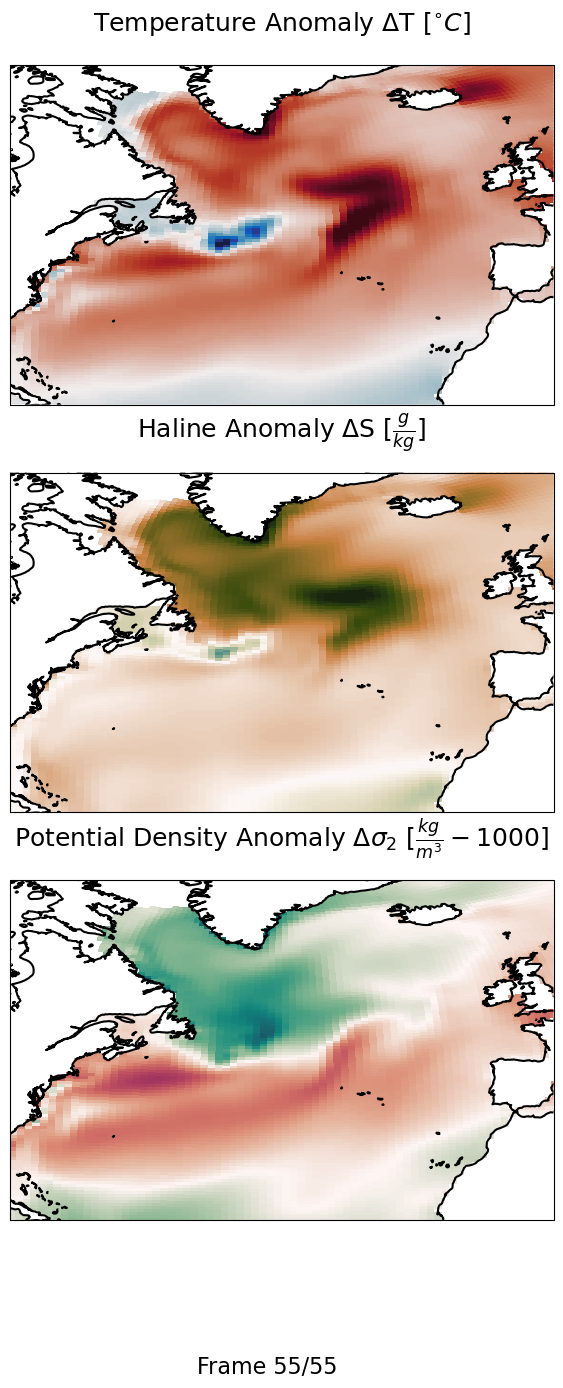

In [8]:
# Initialize Plot Elements
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), subplot_kw={'projection': ccrs.PlateCarree()})
plt.rc('font', size=18)

# Initialize placeholders for plots
plots = []

for row in range(len(variables)):
    ax = axes[row]
    # Create an initial blank plot
    plot = ax.pcolormesh(np.zeros((10, 10)), vmin=vmins[row], vmax=-vmins[row], cmap=cmaps[row], transform=ccrs.PlateCarree())
    plots.append(plot)
    ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=1.5, edgecolor='black')  # Adding coastlines
    ax.set_title(labels[row], fontsize=18, pad=25)

fig.suptitle('Animation of Hydrographic Variable Anomalies', fontsize=20, fontweight='bold', x=0.5, y=0.95)

# Define the animation update function
def update(frame):
    for row, var in enumerate(variables):
        ax = axes[row]
        ds_var_annual = datasets[var].sel(z_t=slice(5.0000000e+02, 1.050000e+04)).mean('z_t')
        ds = ds_var_annual - ds_var_annual.isel(time=slice(0, 40)).mean('time')
        vmin, vmax = vmins[row], -vmins[row]

        ax.clear()  # Clear the axes to remove old plot
        ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, linewidth=1.5, edgecolor='black')

        # Update pcolormesh with actual data
        plots[row] = ds[var].isel(time=frame).plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            x='TLONG',
            y='TLAT',
            cmap=cmaps[row],
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        )
        
        # Set the title
        ax.set_title(labels[row], fontsize=18, pad=25)

    fig.suptitle(f'Frame {frame+1}/{total_time_range}', fontsize=16, x=0.5, y=0.02)
    return plots

# Total time range based on your data
total_time_range = 60
update_interval = 300  # Interval in milliseconds

# Create the animation
ani = FuncAnimation(fig, update, frames=total_time_range, interval=update_interval, blit=False)

# Save the animation as a GIF
output_gif = os.path.expanduser('~/phase1_CONDA/results/hydrographic_variable_anomalies.gif')
ani.save(output_gif, writer='pillow', fps=3, dpi=200)

plt.show()

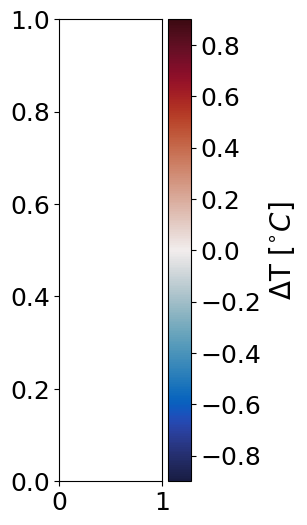

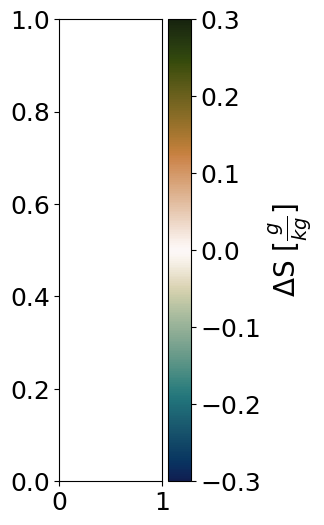

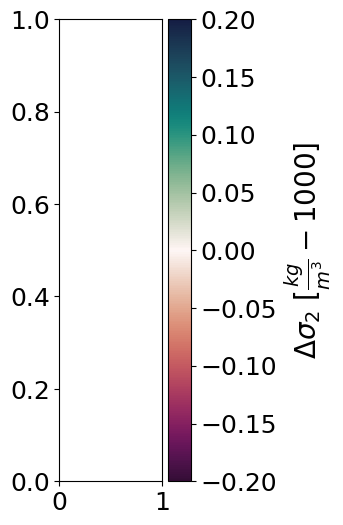

Colorbar figures saved to /home/innag3580/phase1_CONDA/results/colorbars/


In [14]:
# Example data for variable properties (replace with actual data)
labels = [r'$\Delta$T [$^{\circ} C$]', r'$\Delta$S [$\frac{g}{kg}$]', r'$\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r]
vmins = [-0.9, -0.3, -0.2]
vmaxs = [0.9, 0.3, 0.2]     # Example max values (You can adjust this according to your data)

# Directory to save the colorbar figures
output_dir = os.path.expanduser('~/phase1_CONDA/results/colorbars/')

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Create a figure for each colorbar
for idx, (label, cmap, vmin, vmax) in enumerate(zip(labels, cmaps, vmins, vmaxs)):
    fig, ax = plt.subplots(figsize=(2, 6))
    
    # Create a colormap scalar mappable
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for scalar mappable
    
    # Add colorbar to the figure
    cbar = fig.colorbar(sm, ax=ax, fraction=0.3, pad=0.04)
    cbar.set_label(label, fontsize=labelsize)
    
    plt.show()
    
    # Save the colorbar figure
    output_path = os.path.join(output_dir, f'colorbar_{idx + 1}.png')
    fig.savefig(output_path, bbox_inches='tight', dpi=300)
    
    plt.close(fig)

print(f"Colorbar figures saved to {output_dir}")